In [1]:
import wooldridge
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

## 3a) Let’s first start with our “kitchen sink” regression model stndfnl ~ attend + termGPA + priGPA + ACT + hwrte + frosh + soph with entire data set attend. 

In [2]:
df = wooldridge.data('attend')

In [3]:
df.head()

,attend,termGPA,priGPA,ACT,final,atndrte,hwrte,frosh,soph,missed,stndfnl
0,27,3.19,2.64,23,28,84.375,100.0,0,1,5,0.472689
1,22,2.73,3.52,25,26,68.750,87.5,0,0,10,0.052521
2,30,3.00,2.46,24,30,93.750,87.5,0,0,2,0.892857
3,31,2.04,2.61,20,27,96.875,100.0,0,1,1,0.262605
4,32,3.68,3.32,23,34,100.000,100.0,0,1,0,1.733193


In [4]:
pct_60 = np.percentile(df.stndfnl, 60)
df['pass'] = df['stndfnl'].apply(lambda x: 1 if x > pct_60 else 0)
df.head()

,attend,termGPA,priGPA,ACT,final,atndrte,hwrte,frosh,soph,missed,stndfnl,pass
0,27,3.19,2.64,23,28,84.375,100.0,0,1,5,0.472689,1
1,22,2.73,3.52,25,26,68.750,87.5,0,0,10,0.052521,0
2,30,3.00,2.46,24,30,93.750,87.5,0,0,2,0.892857,1
3,31,2.04,2.61,20,27,96.875,100.0,0,1,1,0.262605,0
4,32,3.68,3.32,23,34,100.000,100.0,0,1,0,1.733193,1


In [5]:
df = df.dropna(how='any').reset_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 674 entries, 0 to 673
Data columns (total 13 columns):
index      674 non-null int64
attend     674 non-null int64
termGPA    674 non-null float64
priGPA     674 non-null float64
ACT        674 non-null int64
final      674 non-null int64
atndrte    674 non-null float64
hwrte      674 non-null float64
frosh      674 non-null int64
soph       674 non-null int64
missed     674 non-null int64
stndfnl    674 non-null float64
pass       674 non-null int64
dtypes: float64(5), int64(8)
memory usage: 68.6 KB


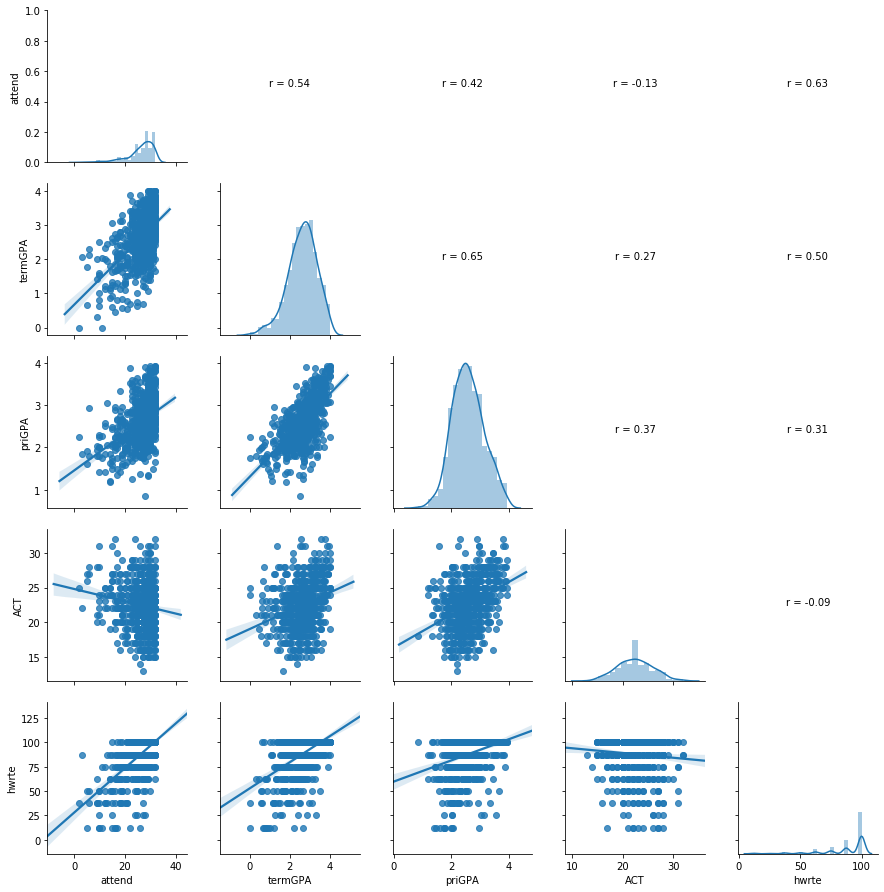

In [6]:
from scipy.stats import pearsonr
def reg_coef(x,y,label=None,color=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()

g = sns.PairGrid(df[["attend", "termGPA", "priGPA", "ACT", "hwrte"]])
g.map_diag(sns.distplot)
g.map_lower(sns.regplot)
g.map_upper(reg_coef)

In [7]:
Y = df["stndfnl"]
X = df[["attend", "termGPA", "priGPA", "ACT", "hwrte", "frosh", "soph"]]
X = sm.add_constant(X) # adding a constant
model = sm.OLS(Y, X, missing='drop').fit()
predictions = model.predict(X) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                stndfnl   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     48.42
Date:                Sat, 20 Feb 2021   Prob (F-statistic):           1.32e-55
Time:                        18:27:14   Log-Likelihood:                -812.24
No. Observations:                 674   AIC:                             1640.
Df Residuals:                     666   BIC:                             1677.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4114      0.306     -7.880      0.0

### (3a-1) using linearHypothesis() to jointly test if forsh = soph = 0, i.e. transition into college does not affect class performance and draw your conclusion for the test; 

#### Answer: since p-value here is 0.1146, it means that we can not reject H0(forsh = soph = 0 ), so this means that on average, freshme and soph does  affect standardized final test score


In [8]:
hypotheses = 'frosh = soph = 0'
f_test = model.f_test(hypotheses)
print(f_test)

<F test: F=array([[2.17268287]]), p=0.11467816570552815, df_denom=666, df_num=2>


### (3a-2) run a automated backward model selection using step() function and interpret the coefficient of attend. (4 points)

#### Answer: On average , when student attendance increase 1, the standardized final test score will decrease by 0.02, holding all other constants except priGPA, frosh and hwrte unchanged. These three variables are omitted based on the automated backward selection.

In [9]:
#Copyright 2019 Sinan Talha Hascelik
#
#Licensed under the Apache License, Version 2.0 (the "License");
#you may not use this file except in compliance with the License.
#You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
#Unless required by applicable law or agreed to in writing, software
#distributed under the License is distributed on an "AS IS" BASIS,
#WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#See the License for the specific language governing permissions and
#limitations under the License.

import numpy as np
import pandas as pd
import statsmodels.api as sm

def backwardSelection(X, y, model_type ="linear",elimination_criteria = "aic", varchar_process = "dummy_dropfirst", sl=0.05):
    """
    Backward Selection is a function, based on regression models, that returns significant features and selection iterations.\n
    Required Libraries: pandas, numpy, statmodels
    
    Parameters
    ----------
    X : Independent variables (Pandas Dataframe)\n
    y : Dependent variable (Pandas Series, Pandas Dataframe)\n
    model_type : 'linear' or 'logistic'\n
    elimination_criteria : 'aic', 'bic', 'r2', 'adjr2' or None\n
        'aic' refers Akaike information criterion\n
        'bic' refers Bayesian information criterion\n
        'r2' refers R-squared (Only works on linear model type)\n
        'r2' refers Adjusted R-squared (Only works on linear model type)\n
    varchar_process : 'drop', 'dummy' or 'dummy_dropfirst'\n
        'drop' drops varchar features\n
        'dummy' creates dummies for all levels of all varchars\n
        'dummy_dropfirst' creates dummies for all levels of all varchars, and drops first levels\n
    sl : Significance Level (default: 0.05)\n
    

    Returns
    -------
    columns(list), iteration_logs(str)\n\n 
    """
    X = __varcharProcessing__(X,varchar_process = varchar_process)
    return __backwardSelectionRaw__(X, y, model_type = model_type,elimination_criteria = elimination_criteria , sl=sl)

def __varcharProcessing__(X, varchar_process = "dummy_dropfirst"):
    
    dtypes = X.dtypes
    if varchar_process == "drop":   
        X = X.drop(columns = dtypes[dtypes == np.object].index.tolist())
        print("Character Variables (Dropped):", dtypes[dtypes == np.object].index.tolist())
    elif varchar_process == "dummy":
        X = pd.get_dummies(X,drop_first=False)
        print("Character Variables (Dummies Generated):", dtypes[dtypes == np.object].index.tolist())
    elif varchar_process == "dummy_dropfirst":
        X = pd.get_dummies(X,drop_first=True)
        print("Character Variables (Dummies Generated, First Dummies Dropped):", dtypes[dtypes == np.object].index.tolist())
    else: 
        X = pd.get_dummies(X,drop_first=True)
        print("Character Variables (Dummies Generated, First Dummies Dropped):", dtypes[dtypes == np.object].index.tolist())
    
    X["intercept"] = 1
    cols = X.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    X = X[cols]
    
    return X


def __backwardSelectionRaw__(X, y, model_type ="linear",elimination_criteria = "aic", sl=0.05):
    
    iterations_log = ""
    last_eleminated = ""    
    cols = X.columns.tolist()

    def regressor(y,X, model_type=model_type):
        if model_type =="linear":
            regressor = sm.OLS(y, X).fit()
        elif model_type == "logistic":
            regressor = sm.Logit(y, X).fit()
        else:
            print("\nWrong Model Type : "+ model_type +"\nLinear model type is seleted.")
            model_type = "linear"
            regressor = sm.OLS(y, X).fit()
        return regressor
    for i in range(X.shape[1]):
        if i != 0 :          
            if elimination_criteria == "aic":
                criteria = model.aic
                new_model = regressor(y,X)
                new_criteria = new_model.aic
                if criteria < new_criteria:
                    print("Regained : ", last_eleminated)
                    iterations_log += "\n"+str(new_model.summary())+"\nAIC: "+ str(new_model.aic) + "\nBIC: "+ str(new_model.bic)+"\n"
                    iterations_log += str("\n\nRegained : "+last_eleminated + "\n\n")
                    break  
            elif elimination_criteria == "bic":
                criteria = model.bic
                new_model = regressor(y,X)
                new_criteria = new_model.bic
                if criteria < new_criteria:
                    print("Regained : ", last_eleminated)
                    iterations_log += "\n"+str(new_model.summary())+"\nAIC: "+ str(new_model.aic) + "\nBIC: "+ str(new_model.bic)+"\n"
                    iterations_log += str("\n\nRegained : "+last_eleminated + "\n\n")
                    break  
            elif elimination_criteria == "adjr2" and model_type =="linear":
                criteria = model.rsquared_adj
                new_model = regressor(y,X)
                new_criteria = new_model.rsquared_adj
                if criteria > new_criteria:
                    print("Regained : ", last_eleminated)
                    iterations_log += "\n"+str(new_model.summary())+"\nAIC: "+ str(new_model.aic) + "\nBIC: "+ str(new_model.bic)+"\n"
                    iterations_log += str("\n\nRegained : "+last_eleminated + "\n\n")
                    break  
            elif elimination_criteria == "r2" and model_type =="linear":
                criteria = model.rsquared
                new_model = regressor(y,X)
                new_criteria = new_model.rsquared
                if criteria > new_criteria:
                    print("Regained : ", last_eleminated)
                    iterations_log += "\n"+str(new_model.summary())+"\nAIC: "+ str(new_model.aic) + "\nBIC: "+ str(new_model.bic)+"\n"
                    iterations_log += str("\n\nRegained : "+last_eleminated + "\n\n")
                    break   
            else: 
                new_model = regressor(y,X)
            model = new_model
            iterations_log += "\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n"
        else:
            model = regressor(y,X)
            iterations_log += "\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n"
        maxPval = max(model.pvalues)
        cols = X.columns.tolist()
        if maxPval > sl:
            for j in cols:
                if (model.pvalues[j] == maxPval):
                    print("Eliminated :" ,j)
                    iterations_log += str("\n\nEliminated : "+j+ "\n\n")
                    
                    del X[j]
                    last_eleminated = j
        else:
            break
    print(str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic))
    print("Final Variables:", cols)
    iterations_log += "\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n"
    return cols, iterations_log

In [10]:
Y = df["stndfnl"]
X = df[["attend", "termGPA", "priGPA", "ACT", "hwrte", "frosh", "soph"]]
backwardSelection(X,Y)

Character Variables (Dummies Generated, First Dummies Dropped): []
Eliminated : priGPA
Eliminated : frosh
Eliminated : hwrte
Eliminated : soph
Regained :  soph
                            OLS Regression Results                            
Dep. Variable:                stndfnl   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     83.88
Date:                Sat, 20 Feb 2021   Prob (F-statistic):           1.01e-57
Time:                        18:27:15   Log-Likelihood:                -813.90
No. Observations:                 674   AIC:                             1638.
Df Residuals:                     669   BIC:                             1660.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P

(['intercept', 'attend', 'termGPA', 'ACT', 'soph'],
 '\n                            OLS Regression Results                            \n==============================================================================\nDep. Variable:                stndfnl   R-squared:                       0.337\nModel:                            OLS   Adj. R-squared:                  0.330\nMethod:                 Least Squares   F-statistic:                     48.42\nDate:                Sat, 20 Feb 2021   Prob (F-statistic):           1.32e-55\nTime:                        18:27:15   Log-Likelihood:                -812.24\nNo. Observations:                 674   AIC:                             1640.\nDf Residuals:                     666   BIC:                             1677.\nDf Model:                           7                                         \nCovariance Type:            nonrobust                                         \n================================================================

## (3b) From the correlation matrix at the very begining, we can see that many of the independent variables are highly correlated with each other. Let’s try to summarize the data using principal component analysis (PCA). (6 points)
### (3b-1)Use the prcomp function to conduct a PCA. (We’ll have to feed attendX, not attend, into prcomp)

In [11]:
attendX = df[["attend", "termGPA", "priGPA", "ACT", "hwrte"]]

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(attendX)
PCA_df = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2', 'PC3'])
PCA_df.head()

,PC1,PC2,PC3
0,-12.027277,1.556984,0.354119
1,1.189661,4.621407,1.421193
2,-0.236607,-3.206819,2.447495
3,-12.762469,-2.985152,-1.603818
4,-12.926121,-3.214222,1.727829


### (3b-2) What is the cumulative proportion of variance explained by the first three PCs

In [13]:
# sum cumulative variance from each var
cum_explained_var = []
for i in range(0, len(pca.explained_variance_ratio_)):
    if i == 0:
        cum_explained_var.append(pca.explained_variance_ratio_[i])
    else:
        cum_explained_var.append(pca.explained_variance_ratio_[i] + 
                                 cum_explained_var[i-1])
print("The cumulative proportion of variance explained by the first three PCs are %.2f, %.2f and %.2f"%(cum_explained_var[0], cum_explained_var[1], cum_explained_var[2]))

The cumulative proportion of variance explained by the first three PCs are 0.93, 0.97 and 1.00


### (3b-3)Extract the first three PCs and pass them to attend. We’ll be using these as predictors.

In [14]:
# Concat with col stndfnl
PCA_df = pd.concat([PCA_df, df.stndfnl], axis = 1)
PCA_df.head()

,PC1,PC2,PC3,stndfnl
0,-12.027277,1.556984,0.354119,0.472689
1,1.189661,4.621407,1.421193,0.052521
2,-0.236607,-3.206819,2.447495,0.892857
3,-12.762469,-2.985152,-1.603818,0.262605
4,-12.926121,-3.214222,1.727829,1.733193


## (3c) Construct and run a logistic regression with entire data set attend, run a logistic regression of pass on the top three principal components. Which coefficients are statistically significant?

### Answer: Based on model result, the coefficients of PC1 and PC3 are statistically significant.

In [15]:
Y = PCA_df["stndfnl"]
X = PCA_df[['PC1', 'PC2', 'PC3']]
X = sm.add_constant(X)
gamma_model = sm.GLM(Y, X, family=sm.families.Binomial())
gamma_results = gamma_model.fit(type='response')
print(gamma_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                stndfnl   No. Observations:                  674
Model:                            GLM   Df Residuals:                      670
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sat, 20 Feb 2021   Deviance:                          inf
Time:                        18:27:16   Pearson chi2:                 2.72e+18
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.122e+09   5317.770  -1.15e+06      0.0

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
PCA_df["pred_pass"]= [0 if x < 0.5 else 1 for x in gamma_results.predict() ]
PCA_df["stndfnl_pass"] = PCA_df["stndfnl"].apply(lambda x: 0 if x < 0.5 else 1)
PCA_df.head(10)

,PC1,PC2,PC3,stndfnl,pred_pass,stndfnl_pass
0,-12.027277,1.556984,0.354119,0.472689,0,0
1,1.189661,4.621407,1.421193,0.052521,0,0
2,-0.236607,-3.206819,2.447495,0.892857,0,1
3,-12.762469,-2.985152,-1.603818,0.262605,0,0
4,-12.926121,-3.214222,1.727829,1.733193,0,1
5,-12.333412,0.443218,3.768803,-0.157563,1,0
6,12.043935,-6.130654,-0.199868,-3.308824,0,0
7,-11.840159,2.293258,-1.005113,1.733193,0,1
8,-11.457273,4.708542,0.419185,0.052521,0,0
9,-12.411572,-0.861009,-1.062597,0.052521,0,0


In [17]:
PCA_df["pred_pass"].value_counts()

0    543
1    131
Name: pred_pass, dtype: int64

## (3d) Finally, let’s manually construct a classification matrix using table() function in base R rather than caret::confusionMatrix(). Use table(x1, x2) with both your model’s “Pass/Fail” predictions and the actual observed pass values. I recommend using the same convention in the lecture slides, where we have actual values on the columns and model prediction on the rows. We say “pass” as possitive event. (4 points)

In [18]:
table = pd.crosstab(PCA_df["pred_pass"], PCA_df["stndfnl_pass"], rownames=['Predict'], colnames=['Actual'])
table.head()

Actual,0,1
Predict,,
0,420,123
1,55,76


In [19]:
# How many True Positives are there?  
TP = 76
print("TP is 76")
# How many True Negatives are there?  
TN = 420
print("TN is 420")
# How many False Positives are there? 
FP = 55
print("FP is 55")
# How many False Negatives are there? 
FN = 123
print("FN is 123")
# What is the model’s overall classification accuracy? 
Accuracy = (TP+TN)/(TP+FN+FP+TN)
print("Accuracy is " + str('{0:.2f}'.format(Accuracy)))

# What is the model’s sensitivity? 
Sensitivity = TP/(TP + FN)
print("Sensitivity is " + str('{0:.2f}'.format(Sensitivity)))

# What is the model’s precision?  
Precision = TP/(TP + FP)
print("Precision is " + str('{0:.2f}'.format(Precision)))

# What is the model’s F1-score? 
F1 = (2 * Precision * Sensitivity)/(Precision + Sensitivity)
print("F1-score is " + str('{0:.2f}'.format(F1)))


TP is 76
TN is 420
FP is 55
FN is 123
Accuracy is 0.74
Sensitivity is 0.38
Precision is 0.58
F1-score is 0.46
